<a href="https://colab.research.google.com/github/correamv/Data_Science/blob/main/Churn_Prediction_Telecom_Company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, também conhecido como taxa de rotatividade ou simplesmente *churn*, é uma métrica utilizada para medir a taxa de perda de clientes ou usuários de um determinado serviço ao longo de um período de tempo específico.

No contexto de um banco por exemplo, o churn rate seria a proporção de clientes que encerram suas contas bancárias ou deixam de utilizar os serviços oferecidos pelo banco.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

Uma alta taxa de churn pode indicar problemas de satisfação do cliente, qualidade dos serviços, concorrência acirrada ou outros fatores que levam os clientes a abandonar a empresa em questão. Portanto, é importante para as instituições monitorar e reduzir o churn rate, implementando estratégias de retenção de clientes, melhorando a experiência do usuário e fornecendo serviços competitivos e de qualidade.

## Escopo do projeto e Aquisição dos Dados

Neste projeto, usaremos técnicas de machine learning para criar um modelo que possa prever com certa acurácia e com isso, utilizar técnicas de retenção de clientes de forma mais eficaz.

Os dados utilizados neste projeto foram originalmente disponibilizados na plataforma de ensino da IBM Developer, e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv) ou no [Github](https://github.com/IBM/telco-customer-churn-on-icp4d) da IBM.

Apesar de não haver informações explícitas disponíveis, os nomes das colunas permitem um entendimento a respeito do problema.

In [35]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [55]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

#Configurando o estilo gráfico dos plots
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = "11"
plt.rcParams["text.color"] = "#515151"
cinza_texto="#515151"
sns.set_style("white")


# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [37]:
print(f'Linhas: {df.shape[0]}')
print(f'Colunas: {df.shape[1]}')

Linhas: 7043
Colunas: 21


Observando as primeiras entradas, já podemos tirar algumas conclusões preliminares sobre os dados:


* Conseguimos montar os perfis dos usuários com as variáveis presentes;
* A maior parte das variáveis é categórica, sendo necessário um processo de *encoding*, para que o modelo consiga ser treinado efetivamente nos dados.
* A feature Churn é a nossa variável alvo, que define se um usuário irá cancelar ou não o serviço.
* A variável `customerID` parece nos dar apenas um identificação única para cada cliente. Para o problema que trataremos aqui, podemos descartar essa informação.



## Análise Exploratória dos Dados

Iniciaremos agora a análise exploratória, para entermos melhor o dataset e como podemos tratar estes dados para o modelo.

Informações como percentual de valores ausentes, número de valores únicos por variável e seus tipos, são fundamentais dentro de qualquer análise.

In [38]:
#Exibindo informações de valores nulos e dos tipos de dados
print("------ Exibindo informações do dataframe ------\n")
df.info()
print("\n")
print("------ Exibindo os valores únicos de cada coluna ------\n")
df.nunique()

------ Exibindo informações do dataframe ------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Com estas novas informações, conseguimos tirar novas conclusões:

* A variável ´customerID´ é única para cada linha do dataframe, isso significa que ela representa um valor de identificação único para cada cliente, como suspeitávamos. Logo, não precisamos utilizá-la.

* A maior parte das variáveis é categórica e assumem poucos valores, como já mencionado.

* Nossa variável alvo é a variável churn, que indica se houve ou não cancelamento por parte daquele cliente. Ela será utilizada pelo modelo para entender e prever qual a probabilidade de cancelamento que um novo cliente possui.

* Aparentemente não possuímos valores ausentes, porém precisamos olhar mais a fundo.

* Observando os dados da variável TotalCharges percebemos que eles não condizem com o seu tipo. Temos dados numéricos, porém com a tipagem object. Precisaremos realizar a conversão e o tratamento desses dados.

#### Dicionário de Variáveis

Vamos agora extrair os valores únicos de cada variável para nos auxiliar na construção do Dicionário de Variáveis.

In [39]:
#Armazenando um array com os nomes das colunas em uma variável
variavel = pd.array(df.columns)

#Criando um lanço no array para exibir os valores únicos de cada coluna
print('Valores únicos em cada variável\n')

for a in variavel:
  print("Variável {}".format(a),": {}".format(df[a].unique()))

Valores únicos em cada variável

Variável customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Variável gender : ['Female' 'Male']
Variável SeniorCitizen : [0 1]
Variável Partner : ['Yes' 'No']
Variável Dependents : ['No' 'Yes']
Variável tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Variável PhoneService : ['No' 'Yes']
Variável MultipleLines : ['No phone service' 'No' 'Yes']
Variável InternetService : ['DSL' 'Fiber optic' 'No']
Variável OnlineSecurity : ['No' 'Yes' 'No internet service']
Variável OnlineBackup : ['Yes' 'No' 'No internet service']
Variável DeviceProtection : ['No' 'Yes' 'No internet service']
Variável TechSupport : ['No' 'Yes' 'No internet service']
Variável StreamingTV : ['No' 'Yes' 'No internet service']
Variável StreamingMovies : ['No' 'Yes

Com os valores extraídos conseguimos entender melhor do que se trata cada variável. Logo:

* **customerID**: identificação única do cliente.
* **gender**: gênero do cliente: Male, Famale.
* **SeniorCitizen**: se o cliente é idoso: Sim: 1, Não: 0.
* **Partner**: se o cliente possui companheiro(a): Sim, Não.
* **Dependents**: se o cliente possui dependentes: Sim, Não.
* **tenure**: número de meses em que o cliente está na empresa (com serviço contrado/é cliente).
* **PhoneService**: Se o cliente possui serviços telefônicos contratados: Sim, Não.
* **MultipleLines**: Se o cliente possui múltiplas linhas de telefone: Sim, Não, Sem serviços telefônicos.
* **InternetService**: Se o cliente optou por serviços de internet: DSL, Fibra óptica, Não.
* **OnlineSecurity**: Se o cliente optou pelos serviços de segurança online: Sim, Não, Sem serviços de internet.
* **OnlineBackup**: Se o cliente optou por serviços de backup online: Sim, Não, Sem serviços de internet.
* **DeviceProtection**: Se o cliente optou por serviços de proteção de seu  equipamento: Sim, Não, Sem serviços de internet.
* **TechSupport**: Se o cliente optou por serviços de ajuda técnica: Sim, Não, Sem serviços de internet.
* **StreamingTV**: Se o cliente optou por serviços de streaming na TV: Sim, Não, Sem serviços de internet.
* **StreamingMovies**: Se o cliente optou por serviços de streaming de filmes: Sim, Não, Sem serviços de internet.
* **Contract**: Tipo de contrato do cliente: mensal, anual, dois anos.
* **PaperlessBilling**: Se o cliente optou pelo faturamento online: Sim, Não.
* **PaymentMethod**: Forma de pagamento: cheque eletrônico, cheque por correios, transferência bancária, cartão de crédito.
* **MonthlyCharges**: Fatura mensal.
* **TotalCharges**: Valor total das faturas durante todo o período de contrato do cliente.
* **Churn**: Se o cliente cancelou o contrato: Sim, Não.

Continuando a análise devemos agora converter a variável `TotalCharges` de object para float. Porém se tentarmos fazer isso diretamente usando a função `astype()`, encontraremos um erro. Isto porque na variável, temos valores que não podem ser convertidos, como por exemplo espaços ou vírgulas.

Assim, para conseguir converter adequadamente, criei uma função para lidar com essa exceção. Ao final, identifiquei que dados ausentes foram encontrados, e substitui pelo valor da mediana da coluna.

In [40]:
def converter_str_float(entrada):
    """
    Converte um objeto do tipo string em float.

    # Arguments
        entrada: string, string da coluna TotalCharges.

    # Returns
        Valor convertido em float, caso permita a conversão.
        NaN, caso o valor não seja apropriado.
    """

    try:
        return float(entrada)
    except ValueError:
        return np.nan

# criar cópia do dataframe
df_clean = df.copy()

# remover coluna costumerID
df_clean.drop("customerID", axis=1, inplace=True)

# converter as strings de TotalCharges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# verificar entradas ausentes
print("Dados ausentes em 'TotalCharges' (antes):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Dados ausentes em 'TotalCharges' (antes):	11



Apesar deste dataset ser composto majoritariamente por variáveis binárias ou categóricas, é possível ver abaixo, pelo método `describe`, que não há indícios da presença de outliers.

In [41]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Para reforçar esta hipótese, iremos plotar os gráficos de boxplot das variáveis `MonthlyCharges` e `TotalCharges`. Podemos ver que o threshold padrão não acusou nenhum plot fora dos limites superior e inferior.

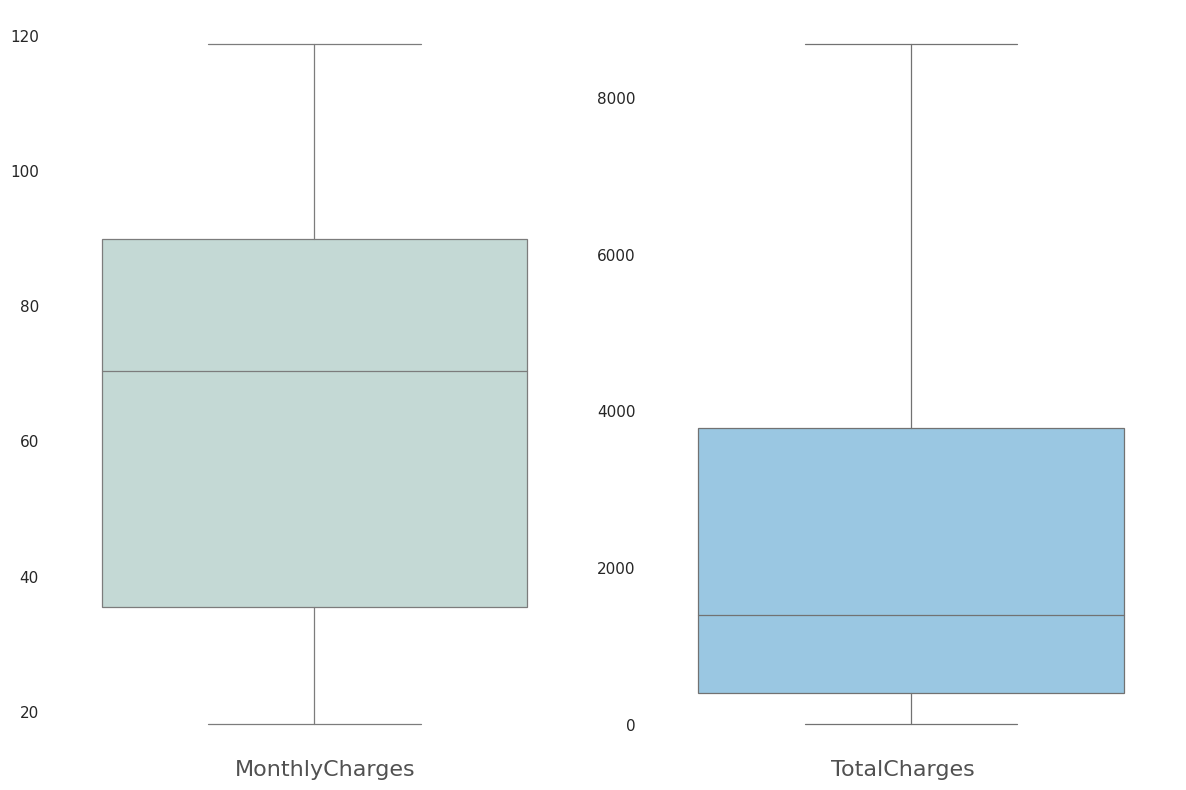

In [42]:
fig, ax = plt.subplots( ncols=2, figsize=(12, 8))

#Retirando as Spines
sns.despine(top=True, right=True, left=True,bottom=True)

#Criando e configurando o primeiro boxplot
box1=sns.boxplot(y=df_clean.MonthlyCharges,  ax=ax[0], linewidth=.9, color='#c0ddd7')
box1.text(-0.15, 10.5, 'MonthlyCharges', fontsize=16, color=cinza_texto)
box1.set(ylabel=None)

#Criando e configurando o segundo boxplot
box2=sns.boxplot(y=df_clean.TotalCharges,  ax=ax[1], linewidth=.9, color='#8ecaee')
box2.text(-0.15, -650, 'TotalCharges', fontsize=16, color=cinza_texto)
box2.set(ylabel=None)

plt.tight_layout()


A variável `tenure` está relacionada ao tempo que um cliente permance assinando determinado serviço. Em outras palavras, pode-se dizer que é um indicativo de fidelidade.

Apesar de não haver nenhuma documentação, assumo que a unidade de tempo utilizada é "mês", tendo em vista os valores das outras variáveis.

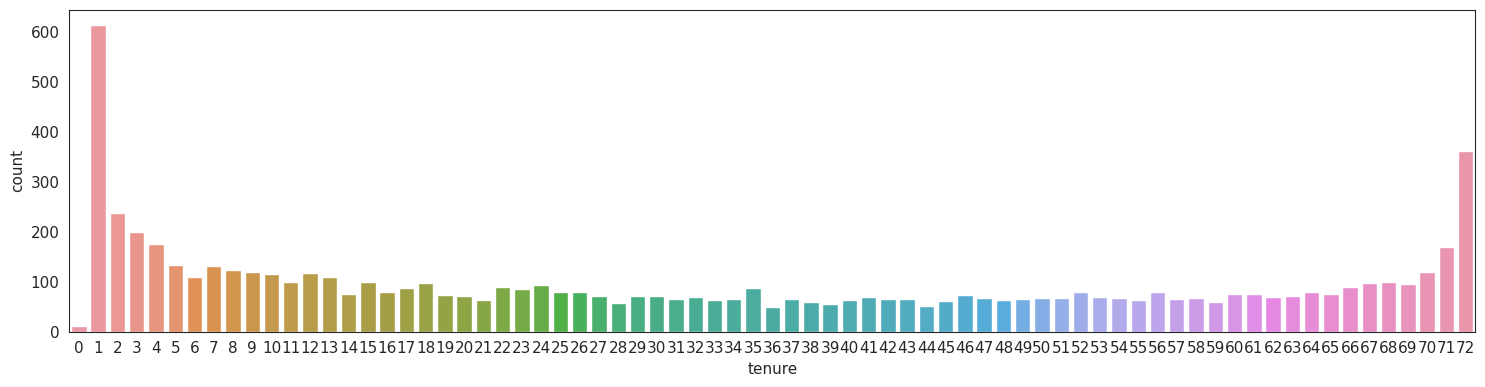

In [43]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.countplot(x=df['tenure'])
plt.tight_layout()


E para finalizar esta primeira etapa exploratória dos dados, irei verificar o balanceamento da variável alvo `churn`.

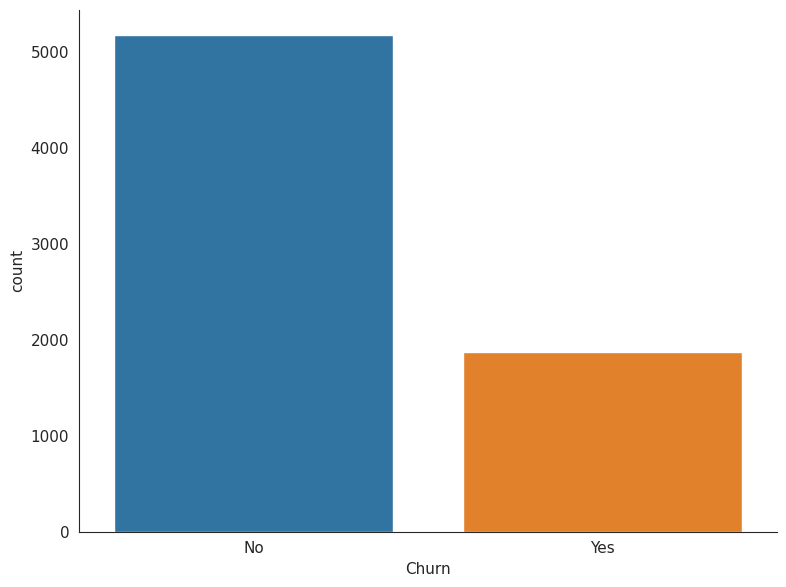

In [44]:
fig, ax = plt.subplots(figsize=(8,6))

plt.rcParams['font.family'] = 'Arial'
sns.countplot(x=df['Churn'])

#removendo spines da direita e superior
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

Como podemos ver, existem muito mais ocorrências de valores em que não temos Churn. Isso torna o dataset desbalanceado, e tal informação será fundamental na hora de construir os modelos de Machine Learning.

## Preparar os Dados

Nesta etapa vou separar os tipos de variáveis (binárias, numéricas e categóricas). As binárias serão processadas pelo *LabelEncoder*, o qual vai substituir os valores classificados como object para 0 e 1 (Isso inclui a variável alvo). Já as categóricas, serão transformadas em variáveis *dummies*, ou seja, os valores das colunas se tornarão variáveis que terão valores 0 ou 1, sendo que 0 representa ausência ou negação da afirmação, e 1 a presença ou confirmação.

In [45]:
# pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe
df_proc = df_clean.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


### Modelos de Machine Learning

Com as etapas anteriores de processamento, os dados já podem ser usados nos modelos de Machine Learning.

Neste primeiro momento não faremos nenhum ajuste mais sofisticado nos hiperparâmetros, assim como não iremos balancear os dados, fazer feature engineering ou feature selection. A primeira coisa será criar uma baseline para poder comparar o desempenho e a evolução dos modelos.

Além disso, é muito importante separar os dados para treino e teste (lembrando que os dados de teste são usados somente na última etapa, para obter uma avaliação mais real).

In [46]:
# separar a feature matrix da target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y)

Irei usar a cross-validation para estimar o erro da baseline e dos modelos iniciais. Para facilitar e melhorar o código, foi criada uma função `val_model`. A métrica utilizada para avaliação será `recall`, pois em previsões relacionadas a Churn Rate, os Positivos Verdadeiros (TP) são os dados mais importantes no momento de obter os resultados.

In [47]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """

    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))

    return scores.mean()

Para criar a baseline, vou usar os dados de treino no classificador Random Forest, sem alterar os parâmetros.

In [48]:
# criar baseline e ver desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.47 (+/- 0.02)


Uma vez que temos um baseline para comparar se os ajustes melhoram ou pioram o desempenho do modelo, irei realizar o balanceamento dos dados e ver como isso impactará.

A técnica utilizada para o balanaceamento dos dados será o *Under Sampling* e os dados serão padronizados antes do balanceamento. Reforçando que o balanceamento será feito apenas nos dados de treino.

In [49]:
#  padronizar os  dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Under Sampling
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Irei aplicar a validação cruzada a vários modelos, a fim de identificar o seu desempenho e escolher o(s) melhor(es). Novamente, serão utilizados apenas dados de treino. Os modelos escolhidos são:

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Regressão Logística
* LightGBM

In [50]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.769784
DecisionTreeClassifier,0.681295
SGDClassifier,0.733813
SVC,0.790647
LogisticRegression,0.807194
XGBClassifier,0.748201
LGBMClassifier,0.772662


Dadas as características do problema e o desempenho durante as execuções anteriores, optarei pelo XGBoost.

Meu entendimento é que o tuning dos parâmetros pode melhorar ainda mais a qualidade da solução.


## Otimização dos Hiperparâmetros

XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. Uma boa prática é definir uma taxa de aprendizado e número de estimadores, realizar tuning de outros parâmetros e, no final, checar outras taxas de aprendizado.

Abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a `learning_rate=0.1`.

In [51]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(0,1000,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7906474820143885 para {'n_estimators': 50}


Com o número de estimadores igual a 50, realizarei a busca pelos parâmtros `max_depth` e `min_child_weight`.

In [34]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8244604316546763 para {'max_depth': 1, 'min_child_weight': 1}


Obtidos os valores de `max_depth=1` e `min_child_weight=1`, irei otimizar o parâmetro `gamma`.

In [52]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=1, min_child_weight=1)

param_grid = {
 'gamma':[i/10.0 for i in range(0,5)]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8237410071942446 para {'gamma': 0.0}


Por fim, obtido `gamma=0`, vou testar quatro valores para a `learning_rate` e ver qual oferece o melhor resultado.

In [53]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8812949640287769 para {'learning_rate': 0.001}


Para os valores testados, a menor taxa de aprendizado foi aquela capaz de melhorar o desempenho do modelo. Isso exigirá mais passos (steps) no processo de aprendizado do classificador, mas retornará um score melhor para a métrica de recall, que como foi citado antes, é a principal medida adotada para o projeto.

Agora vamos treinar o modelo final com o dataset de treino completo, para depois verificar o seu desempenho com os dados de teste, que permaneciam intactos até o momento.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1282
           1       0.44      0.90      0.59       479

    accuracy                           0.66      1761
   macro avg       0.69      0.73      0.65      1761
weighted avg       0.80      0.66      0.68      1761

AUC: 0.7336



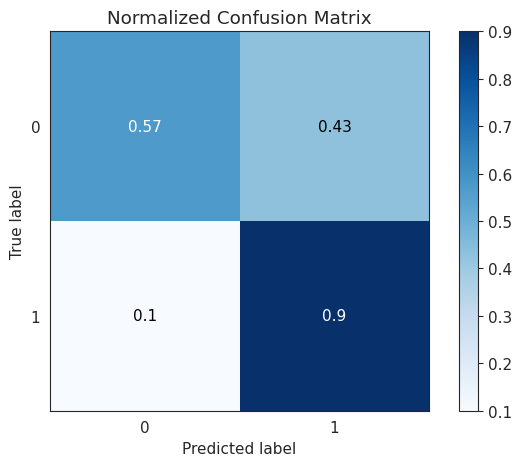

In [56]:
# modelo final
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.tight_layout()

### Conclusões

O modelo final conseguiu um resultado bom, visto que os hiperparâmetros e os dados em geral foram bem otimizados.

A taxa de falso-positivos deve-se a premissa que assumimos de priorizar o recall, já que essa métrica possui um trade-off com a precision. Analisando esse problema, um cliente erroneamente detectado pelo modelo poderia passar a receber algumas das ações voltadas a sua fidelização, o que não necessariamente significa algo ruim, já que são ações que levariam a um aumento de fidelidade e não teriam impacto financeiro grande (talvez apenas uma redução na margem de lucro) e não prejudicariam o cliente. Logo, o retorno financeiro e as vantagens que poderíamos conseguir com o modelo, ao reduzirmos a Churn Rate, ultrapassam as possíveis desvantagens devido à detecção de falso-positivos.

Outras métricas como o CAC (Custo de Aquisição de Clientes) ou o LTV (Valor Vitalício do Cliente) seriam necessárias para uma simulação mais precisa. No entanto, podemos observar que a aplicação do modelo resulta em um alto retorno financeiro e uma significativa redução na taxa de cancelamento de clientes (churn). Isso nos mostra que a utilização de modelos de machine learning em conjunto com técnicas de análise e ciências de dados traz benefícios significativos, não apenas para a saúde financeira da empresa, mas também para a compreensão e análise de problemas complexos em geral. Essas abordagens se mostram como ferramentas valiosas, proporcionando um apoio relevante para o crescimento da empresa e para lidar com desafios diversos de forma mais eficiente.

